

The goal of this assignment is to develop a Feedforward network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)
- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)
- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**4 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**4 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)
- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparam combination  (**2 marks**). 
- After training the model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy.
- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).

- **BONUS:** Extend you Feedforward network by adding more hidden layers (e.g. one more). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**+2 extra marks**)



### Data 

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. You are allowed to re-use your code from Assignment 1.

Please make sure to comment your code. You should also mention if you've used Windows to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1 of ~75-80% and ~85% without and with using pre-trained embeddings respectively. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module. If you implement the bonus question you can get up to 2 extra points but your final grade will be capped at 20.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
data_tr = pd.read_csv("./data_topic/train.csv",header=None, names=['label','text'])
data_te = pd.read_csv("./data_topic/dev.csv",header=None, names=['label','text'])
data_dev = pd.read_csv("./data_topic/test.csv",header=None, names=['label','text'])

In [3]:

X_tr_raw = list(data_tr['text'])
X_test_raw = list(data_te['text'])
X_dev_raw = list(data_dev['text'])

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [4]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [5]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    tokenRE = re.compile(token_pattern)

    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
    
    # this is to store the ngrams to be returned
    x = []
    
    if ngram_range[0]==1:
        x = x_uni

    if ngram_range[1] == 1:
        return x
    
    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
        
        # ignore unigrams
        if n==1: continue
        
        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1]. 
        # Note that x_uni and x_uni[1:] have different lenghts
        # but zip ignores redundant elements at the end of the second list
        # Alternativel, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)
    
        
    for n in ngrams:
        for t in n:
            x.append(t)
        
    if len(vocab)>0:
        x = [w for w in x if w in vocab]
        
    return x



### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [6]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, stop_words=[]):
    tokenRE = re.compile(token_pattern)
    
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
    
    # interate through each raw text
    for x in X_raw:
        
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words)
        
        #update doc and ngram frequencies 
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set. 
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
    
    # keep the top N most freqent 
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) if w[0] in vocab])
    
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1, 1), stop_words=stop_words)


Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [8]:
# generate word and corresponding id
id2word = dict(enumerate(vocab))

word2id = {}
i = 0
for i, w in enumerate(list(vocab)):
    word2id[w] = i
    

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [9]:
X_train_ngram = []
X_dev_ngram = []
X_test_ngram = []

# generate 3 file's ngrams list
for i in X_tr_raw:
    X_train_ngram.append(extract_ngrams(i, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=vocab))
for i in X_dev_raw:
    X_dev_ngram.append(extract_ngrams(i, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=vocab))
for i in X_test_raw:
    X_test_ngram.append(extract_ngrams(i, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=vocab))

Then convert them into lists of indices in the vocabulary:

In [10]:
def uni2id(data, word2id):
    result = []
    for i in range(len(data)):
      row = []
      for j in range(len(data[i])):
          row.append(word2id[data[i][j]])
      result.append(row)
    return result
        

X_tr = uni2id(X_train_ngram, word2id)
X_dev = uni2id(X_dev_ngram, word2id)
X_te = uni2id(X_test_ngram,word2id)

Put the labels `Y` for train, dev and test sets into arrays: 

In [11]:
# -1 to make more convinent when we use this in future steps
Y_tr = data_tr['label'].values -1   
Y_dev = data_dev['label'].values - 1
Y_te = data_te['label'].values -1

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W^T) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i^T $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers (for the Bonus). Empty if there are no hidden layers between the average embedding and the output layer 
- `num_clusses`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

See the examples below for expected outputs. Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [12]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
  output_dim = embedding_dim
  W = []
  W.append(np.random.uniform(-0.1, 0.1, size=(vocab_size, embedding_dim)).astype(np.float32))  # process embeeding layer
  if hidden_dim: 
      W.append(np.random.uniform(-0.1, 0.1, size=(embedding_dim, hidden_dim[0])).astype(np.float32)) # process hidden layer
      output_dim = hidden_dim[0]

  W.append(np.random.uniform(-0.1, 0.1, size=(output_dim, num_classes)).astype(np.float32)) # process output_layer
  return W
    

In [13]:
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=2)

print('W_emb:', W[0].shape)
print('W_out:', W[1].shape)

W_emb: (5, 10)
W_out: (10, 2)


In [14]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

In [15]:
print('W_emb:', W[0].shape)
print('W_h1:', W[1].shape)
print('W_out:', W[2].shape)

W_emb: (3, 4)
W_h1: (4, 2)
W_out: (2, 2)


In [16]:
W[0]

array([[-0.08085749,  0.07706536,  0.02544979,  0.04468327],
       [-0.09677416,  0.01888638,  0.01135704, -0.06820807],
       [-0.06938589,  0.03910591, -0.03624671,  0.03839406]],
      dtype=float32)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. It takes as input:

- `z`: array of real numbers 

and returns:

- `sig`: the softmax of `z`

In [17]:
def softmax(z):
    smax = np.exp(z) / np.sum(np.exp(z))
    return smax

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:

In [18]:
def categorical_loss(y, y_preds):
    loss = -np.log(y_preds[y])
    return loss

In [19]:
# example for 5 classes

y = 2 #true label
y_preds = softmax(np.array([[-2.1,1.,0.9,-1.3,1.5]]))[0]

print('y_preds: ',y_preds)
print('loss:', categorical_loss(y, y_preds))

y_preds:  [0.01217919 0.27035308 0.24462558 0.02710529 0.44573687]
loss: 1.40802648485675


Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network (during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

\begin{equation}
  \text{relu_derivative}(z_i)=\begin{cases}
    0, & \text{if $z_i<=0$}.\\
    1, & \text{otherwise}.
  \end{cases}
\end{equation}

Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [20]:
def relu(z):

  a = np.array([max(x, 0) for x in z])
  return a
    
def relu_derivative(z):    
    return 1 * (z > 0)

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [21]:

def dropout_mask(size, dropout_rate):
  dropout_vec = np.ones(size)
  indexs = random.sample(range(0,size),int(size*dropout_rate))
  for i in indexs:

      dropout_vec[i] = 0

  return dropout_vec

In [22]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[0. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
[1. 0. 1. 1. 1. 1. 0. 1. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [23]:
def predict(h, W):
  preds = softmax(np.matmul(h, W))
  return preds

In [24]:
def forward_pass(x, W, dropout_rate=0.2):
  out_vals = {}
  h_vecs = []
  a_vecs = []
  dropout_vecs = []  
  # produce dropout_mask vectors based on size of hidden layer
  dropout_vecs.append(dropout_mask(W[0].shape[1], dropout_rate))
  # get the weights mapping with x and get mean value
  h = np.sum(W[0][x], axis=0)/len(x)
  h_vecs.append(np.array(h, dtype=np.float32))
  # put relu(h) values into a_vecs
  relu_h = relu(h_vecs[0]) 
  a_vecs.append(np.array(relu_h, dtype=np.float32))# h0   
  # loop all hidden layer
  hid_num = len(W)-1
  for hl in range(1, hid_num):
      # dropout for regularisation.
      dropout = dropout_mask(W[hl].shape[1], dropout_rate)
      h_t = np.dot(h_vecs[hl-1], W[hl])
      # put the dropout into vectors
      h_vecs.append(dropout*h_t)
      a_vecs.append(relu(h_vecs[hl]))
      dropout_vecs.append(dropout)
  
  # make prediction
  if len(W)>1:
      y_pred = predict(h_vecs[hid_num-1], W[-1])
  else:
      y_pred = predict(h_vecs[0], W[-1])

  # compute cross-entropy loss
  out_vals['h'] = h_vecs
  out_vals['a'] = a_vecs
  out_vals['dropout_vec'] = dropout_vecs
  out_vals['y'] = y_pred
  return out_vals


In [25]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

print()
print(forward_pass([2,1], W, dropout_rate=0.5))

Shape W0 (3, 4)
Shape W1 (4, 5)
Shape W2 (5, 2)

{'h': [array([-0.06532356, -0.0525649 , -0.01648912,  0.03281889], dtype=float32), array([-0.        ,  0.00132905, -0.00631938,  0.        ,  0.00368075])], 'a': [array([0.        , 0.        , 0.        , 0.03281889], dtype=float32), array([-0.        ,  0.00132905,  0.        ,  0.        ,  0.00368075])], 'dropout_vec': [array([0., 1., 0., 1.]), array([0., 1., 1., 0., 1.])], 'y': array([0.50001371, 0.49998629])}


The `backward_pass` function computes the gradients and update the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [26]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
  # Derivation of cross-entropy softmax
  y_pd = out_vals['y']
  y2 = np.zeros(y_pd.shape[-1])
  y2[y] = 1
  dy = y_pd - y2
  dy = np.reshape(dy,(1,dy.shape[-1]))
  n = len(W)
  # process hidden layer part
  for i in range(n-1,0,-1):
      # get w gradient
      w_grad = out_vals['a'][i-1].T[:,None].dot(dy)
      # get h gradient
      h_grad = dy.dot(W[i].T)[0]
      #  update w value
      W[i] = W[i] - lr*w_grad
      dy = relu_derivative(h_grad)
      # change it to (1, 300)
      dy = np.reshape(dy,(1,dy.shape[-1]))      
  if not freeze_emb:
      dy = np.reshape(dy,(dy.shape[-1]))
      embed_grad = relu_derivative(dy)
      for id in x:
          W[0][id] = W[0][id] - embed_grad * lr
  return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [27]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    # get training and development data numbers
    X_tr_nums = len(X_tr)
    X_dev_nums = len(X_dev)
    training_loss_history = []
    validation_loss_history = []
    initial_loss = np.inf
    for i in range(epochs):
        # set first value
        training_loss = 0
        for j in range(X_tr_nums):
             # random choose data to train
            index = random.sample(range(0,X_tr_nums),1)[0]
            # get prediction values(output)
            out_vals_ = forward_pass(X_tr[index], W, dropout_rate=dropout)
            # update weights value
            W = backward_pass(X_tr[index], Y_tr[index], W, out_vals_, lr=lr, freeze_emb=freeze_emb)
            # calculate the training loss
            training_loss = training_loss + categorical_loss(Y_tr[index],out_vals_['y'])
         # same with training process
        training_loss_history.append(training_loss)

        dev_loss =0
        for j in range(X_dev_nums):
            index = random.sample(range(0,X_dev_nums),1)[0]
            out_vals_ = forward_pass(X_dev[index], W, dropout_rate=dropout)
            dev_loss +=categorical_loss(Y_dev[index],out_vals_['y'])
        # set a condition which the loop will break when the absolute value of difference between
        # the development loss and initial loss value is smaller than tolerance value
        if abs(dev_loss - initial_loss)<tolerance:
            break
        intial_loss = dev_loss
        # store the validation loss value so we can modify our hyperparameter
        validation_loss_history.append(dev_loss)
        if print_progress:
               print('Epoch times: {}, Training loss value: {}, Validation loss: {}'.format(i, training_loss_history[-1], validation_loss_history[-1]))
        
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [28]:
W = network_weights(vocab_size=len(vocab),embedding_dim=500,hidden_dim=[], num_classes=3)   



W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                    W,
                    X_dev=X_dev, 
                    Y_dev=Y_dev,
                    lr=0.0002, 
                    dropout=0.13,
                    freeze_emb=False,
                    tolerance=0.00001,
                    epochs= 100)

Shape W0 (8931, 500)
Shape W1 (500, 3)
Epoch times: 0, Training loss value: 2600.309010690197, Validation loss: 968.0751727922072
Epoch times: 1, Training loss value: 2530.8971687832013, Validation loss: 945.3029972816872
Epoch times: 2, Training loss value: 2467.8321154483438, Validation loss: 923.3643569192948
Epoch times: 3, Training loss value: 2399.766114026776, Validation loss: 906.5032668785128
Epoch times: 4, Training loss value: 2331.6717149165283, Validation loss: 889.6862233610539
Epoch times: 5, Training loss value: 2283.4148988784864, Validation loss: 879.8747780407047
Epoch times: 6, Training loss value: 2226.8155834496256, Validation loss: 851.0697908934355
Epoch times: 7, Training loss value: 2179.9088670171795, Validation loss: 833.0474563090744
Epoch times: 8, Training loss value: 2121.7954351898056, Validation loss: 823.1385683583885
Epoch times: 9, Training loss value: 2065.134443265823, Validation loss: 806.9236224213142
Epoch times: 10, Training loss value: 2008.5

Epoch times: 89, Training loss value: 1127.5078392062806, Validation loss: 511.8954253769953
Epoch times: 90, Training loss value: 1204.7479629546583, Validation loss: 585.3704651991085
Epoch times: 91, Training loss value: 1320.7237110285173, Validation loss: 571.4031621953288
Epoch times: 92, Training loss value: 1172.70148728041, Validation loss: 546.8774840716098
Epoch times: 93, Training loss value: 1264.9499986901824, Validation loss: 550.0652324413106
Epoch times: 94, Training loss value: 1213.0160671546626, Validation loss: 568.8164063051153
Epoch times: 95, Training loss value: 1255.2794654181328, Validation loss: 633.1524999234567
Epoch times: 96, Training loss value: 1250.9537235612988, Validation loss: 614.0456538323189
Epoch times: 97, Training loss value: 1221.7475607572765, Validation loss: 555.1990001985589
Epoch times: 98, Training loss value: 1294.3318237106016, Validation loss: 631.8311908959625
Epoch times: 99, Training loss value: 1266.3438375316016, Validation los

Plot the learning process:

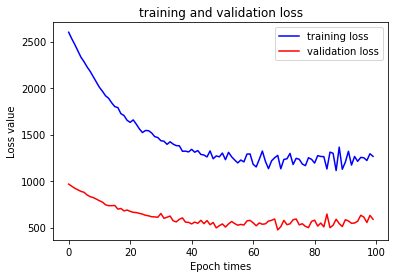

In [29]:
plt.plot(range(len(loss_tr)), loss_tr, c = 'blue', label='training loss')
plt.plot(range(len(dev_loss)), dev_loss,c= 'red', label = 'validation loss', )
plt.xlabel('Epoch times')
plt.ylabel('Loss value')
plt.legend()
plt.title('training and validation loss')
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [30]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8533333333333334
Precision: 0.8626678876678877
Recall: 0.8533333333333334
F1-Score: 0.8521161216942433


In [33]:
del W;gc.collect()

2892

### Discuss how did you choose model hyperparameters ? 

In [37]:
results = pd.read_csv("./data_topic/without_embedding.csv")
results

,embedding size,learning_rate,epoch times,training_loss,validation_loss,F1_score
0,300,0.0001,50,1859.363971,726.056014,0.767048
1,300,0.0002,50,1523.284103,609.565260,0.778959
2,300,0.0003,50,1389.563721,563.135827,0.800343
3,300,0.0001,100,1510.786664,624.218801,0.780528
4,300,0.0002,100,1337.724191,575.832935,0.794092
5,300,0.0003,100,1403.003483,617.541038,0.801646
6,500,0.0001,50,1546.848400,622.759730,0.823929
7,500,0.0002,50,1260.862523,520.833905,0.831746
8,500,0.0003,50,1228.350011,507.423733,0.852116
9,500,0.0001,100,1247.861820,554.763552,0.852040


First set the initial value of the learning rate and training times, then conduct model training, and adjust according to the direction of the obtained loss map. If the overall loss value in the image has been declining, it means that we can increase the learning rate and training slightly. Times, but if the loss value has a tendency to become larger at a certain value, it means that we need to reduce the learning rate. Until the obtained loss value reaches a certain stable point, then the parameters we get are relatively good. In this question, we could see the best parameters combination is embedding_size = 500, learning_rate = 0.0002, epoch times = 100, we could get same F1 score when learning_rate equal to 0.0003, but the loss graph is not good.

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary.

In [29]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            print('start laod glove')
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    print('laod glove success')
    return w_emb

In [30]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id)

start laod glove
laod glove success


First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [31]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3)
W[0] = w_glove

W, loss_tr2, dev_loss2 = SGD(X_tr 
                ,Y_tr
                ,W
                ,X_dev=X_dev
                ,Y_dev=Y_dev
                ,lr=0.0003
                ,dropout=0.13
                ,freeze_emb=True
                ,tolerance=0.001
                ,epochs= 100)

Epoch times: 0, Training loss value: 2467.917977031668, Validation loss: 903.4841431117256
Epoch times: 1, Training loss value: 2354.42828622795, Validation loss: 860.3986879352661
Epoch times: 2, Training loss value: 2248.2384252345632, Validation loss: 834.0434956958086
Epoch times: 3, Training loss value: 2137.3188561763304, Validation loss: 795.5952742495875
Epoch times: 4, Training loss value: 2064.9585644565473, Validation loss: 762.6590469633204
Epoch times: 5, Training loss value: 1989.408171736267, Validation loss: 743.722475859812
Epoch times: 6, Training loss value: 1900.885831220011, Validation loss: 710.7869113690413
Epoch times: 7, Training loss value: 1853.769573813848, Validation loss: 691.7333611874933
Epoch times: 8, Training loss value: 1793.2533923074882, Validation loss: 678.6815405578245
Epoch times: 9, Training loss value: 1733.4157319108836, Validation loss: 640.3327496193023
Epoch times: 10, Training loss value: 1703.7300508552582, Validation loss: 623.39900710

Epoch times: 89, Training loss value: 896.1286106142356, Validation loss: 372.459680096979
Epoch times: 90, Training loss value: 899.3603377451476, Validation loss: 340.71725110836064
Epoch times: 91, Training loss value: 911.5781268796326, Validation loss: 358.24234512782846
Epoch times: 92, Training loss value: 923.049157667369, Validation loss: 354.9606972690713
Epoch times: 93, Training loss value: 864.8780719106525, Validation loss: 371.8573953773691
Epoch times: 94, Training loss value: 850.2862776332147, Validation loss: 358.4155600099787
Epoch times: 95, Training loss value: 882.9749645504908, Validation loss: 391.0189862475687
Epoch times: 96, Training loss value: 860.4140713200528, Validation loss: 322.7755889559283
Epoch times: 97, Training loss value: 866.3305496660637, Validation loss: 356.6112880158469
Epoch times: 98, Training loss value: 846.0914620781159, Validation loss: 363.19752962109555
Epoch times: 99, Training loss value: 903.0529927617876, Validation loss: 342.0

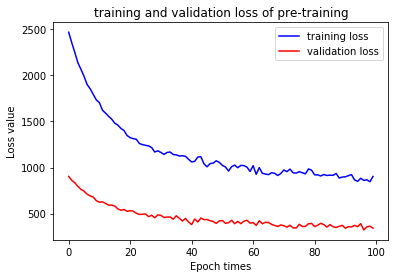

In [32]:
plt.plot(range(len(loss_tr2)), loss_tr2, c = 'blue', label='training loss')
plt.plot(range(len(dev_loss2)), dev_loss2,c= 'red', label = 'validation loss', )
plt.xlabel('Epoch times')
plt.ylabel('Loss value')
plt.legend()
plt.title('training and validation loss of pre-training')
plt.show()

In [33]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))


Accuracy: 0.92
Precision: 0.9220679012345679
Recall: 0.9199999999999999
F1-Score: 0.9203296703296703


In [34]:
del W;gc.collect()

2718

### Discuss how did you choose model hyperparameters ? 

In [35]:
results = pd.read_csv("./data_topic/with_embedding.csv")
results

,learning_rate,epochs,training_loss,dev_loss,F1-score
0,0.0001,50,1480.002935,572.505861,0.901070
1,0.0002,50,1184.898596,443.424084,0.907425
2,0.0003,50,1057.130719,396.984397,0.913868
3,0.0001,100,1157.697179,473.807324,0.907425
4,0.0002,100,976.941802,369.611414,0.920330
5,0.0003,100,903.052993,342.043083,0.920330


Yes, the F1 socre achieve about 0.9, it's better than without pre-training one
It's a little different, we can't use embedding size = 500, so from the previous tuning experience, we fix the embedding size to 300, First set the initial value of the learning rate and training times, then conduct model training, and adjust according to the direction of the obtained loss map. If the overall loss value in the image has been declining, it means that we can increase the learning rate and training slightly. Times, but if the loss value has a tendency to become larger at a certain value, it means that we need to reduce the learning rate. Until the obtained loss value reaches a certain stable point, then the parameters we get are relatively good, from the table, we can find the best combination is learaning_rate = 0.0003, epochs = 100, but we can see the F1 score difference among these parameter combination is small, the smallest value is 0.901070, the best value is 0.920330

# Extend to support deeper architectures (Bonus)

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. 

In [ ]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |  0.8721804511278196  | 0.86 |0.8589193825042881   | 0.86|
| Average Embedding (Pre-trained)  |0.92  | 0.9220679012345679  |0.9199999999999999 |0.9203296703296703   |
| Average Embedding (Pre-trained) + X hidden layers (BONUS)   |   |   |   |   |
